# Signal Preprocessing: Whitening + Bandpass Filter
### Introduction
Welcome to my Signal Preprocessing Notebook. The point of this notebook is to get the signal preprocessing out of the way and arrive at a usable big array containing all the preprocessed signals in this Competition. Since I´m not so experienced, please let me know about possible improvements and errors, which need to be fixed.  

So: What are we going to do? Basically, we´re trying to remove the brunt of noise and downsample the 70gb of data to make all of the information usable.  
In Terms of preprocessing we´re trying to follow this publication about signal preprocessing at the LIGO and VIRGO observatories: https://iopscience.iop.org/article/10.1088/1361-6382/ab685e (Chapter 3 & 4).  
In Short, they downsample their data (with a high pass filter at 20Hz), then whiten their Signal and bandpass filter to get most stuff away except for the relevant irregularities between 35 and 350 Hz.  
Huge Shoutout to https://www.kaggle.com/allunia for her work.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory

import matplotlib.pyplot as plt
import seaborn as sb

import matplotlib.mlab as mlab

# Signal Whitening
## Intro
Obviously, their Detector mostly measures Noise from all sorts of sources. Who knows. However, we are not intrested in all the noise that's constantly going through the detector, we are intrested in very special events that happen rarely. A good way to downweigh the Noise is through a spectral analysis. Basically, we are going to perform a Fourier Transformation/Analysis to record the frequency of occurence of signals with different frequencies.  Then, we are going to downway the more common frequencies by 'making them more silent' and make all the frequencies equally likely to occur (ie Gaussian with mean = 0 and std=1). This way, if something relevant happens, we can easily see an irregular spike in the different frequencies and make signals much more easy to detect.
Imagine a Picture taken through a red window. Obviously, the picture is going to contain to much red and if we are looking for the stuff behind the window, we are going to downway the red pixels and make them less bright to be able to see more detail in the 'signal' behind the widow.

In [ ]:
from scipy.signal import firwin, windows

from multiprocessing import sharedctypes, Pool, Value
import gc

#load the target array just because
training_df = pd.read_csv('/kaggle/input/g2net-gravitational-wave-detection/training_labels.csv')

#record the number of samples
no_samples = len(training_df)

#the amount of signals we`re going to use to record the frequency spectrum (there are a lot of signals ok?)
no_spectral_samples = 100000

#just to thest everything with one signal, load one
test_ts = np.load('/kaggle/input/g2net-gravitational-wave-detection/train/0/0/0/00000e74ad.npy')



#okay, we`re ready, create aresult array to fill in the loaded samples
target_array = np.zeros((no_spectral_samples, 3, test_ts.shape[1]))
print(f'Target-Array-Size: {(target_array.size * target_array.itemsize)/(1024**3)}')

#make it a shared c type array for multiprocessing
target_array = np.ctypeslib.as_ctypes(target_array)
target_array = sharedctypes.RawArray(target_array._type_, target_array)


In [ ]:
#a function to load signals into the array with downsampling
def gather_raw_samples(i):
    #i is the index in the training df
    filename = training_df['id'][i]
    
    #load the signal from the file
    data_array = np.load(f'/kaggle/input/g2net-gravitational-wave-detection/train/{filename[0]}/{filename[1]}/{filename[2]}/{filename}.npy')
    
    #idk we have to pull this hack cuz the data array was strided, which is not supported by shared c types...
    non_strided = np.ones_like(data_array)
    non_strided[:,:] = data_array
    
    #put into into the target array
    data_array = np.ctypeslib.as_ctypes(non_strided)
    target_array[i] = data_array

In [ ]:
idxs = training_df.index[(training_df['target'] == 0)]

In [ ]:
idxs

In [ ]:
#load them with multiprocessing
idxs = (training_df['target'] == 0).index[:no_spectral_samples]
pool = Pool(processes=4)

a= pool.map(gather_raw_samples, idxs, chunksize=1024)

In [ ]:
target_array = np.ctypeslib.as_array(target_array)
gc.collect()

target_array.shape

## Implementation
### Recording the Spectrum
We need to record the spectrum of the Data first, so we loaded a fraction of 50000 samples from their files, downsampled them with a highpass filter at 20Hz and now we're going to perform a fourier transformation of all signals. Because Fourier Analysis has problems with the shap edges of a signal we are going to apply a tukey filter, which is going to let the signals to a cosine decay at the ends. Then the ends are padded with zeros and the FFT (Fast Fourier Transform) is applied.  
We will get the weighing factors for certain frequencies in the sample and average over all the samples to get the power spectrum.

In [ ]:
signal_timesteps = target_array.shape[2]
sampling_freq = signal_timesteps/2

Nfft = signal_timesteps
tukey_window = windows.tukey(Nfft, alpha=0.25)


Pxx0, freqs0 = mlab.psd(target_array[:,0,:].reshape(target_array.shape[0]*target_array.shape[2]),Fs=sampling_freq, NFFT=Nfft, window=tukey_window)
Pxx1, freqs1 = mlab.psd(target_array[:,1,:].reshape(target_array.shape[0]*target_array.shape[2]),Fs=sampling_freq, NFFT=Nfft, window=tukey_window)
Pxx2, freqs2 = mlab.psd(target_array[:,2,:].reshape(target_array.shape[0]*target_array.shape[2]),Fs=sampling_freq, NFFT=Nfft, window=tukey_window)


In [ ]:
from scipy.interpolate import interp1d
psd_0 = interp1d(freqs0, Pxx0)
psd_1 = interp1d(freqs1, Pxx1)
psd_2 = interp1d(freqs2, Pxx2)

### Results
The red crosses are the different values for the frequencies while red line is just a simple moving average of them

In [ ]:
f_min = 20.
f_max = 2000

fig, ax= plt.subplots(nrows=2, ncols=3, figsize=(16,9))

ax[0][0].loglog(freqs0, np.sqrt(Pxx0), label='raw', alpha=0.7)
ax[0][0].axis([f_min, f_max, 4e-24, 1e-22])

ax[0][1].loglog(freqs1, np.sqrt(Pxx1), label='raw', alpha=0.7)
ax[0][1].axis([f_min, f_max, 4e-24, 1e-22])

ax[0][2].loglog(freqs2, np.sqrt(Pxx2), label='raw', alpha=0.7)
ax[0][2].axis([f_min, f_max, 4e-24, 1e-22])

f_min = 20.
f_max = 300

ax[1][0].loglog(freqs0, np.sqrt(Pxx0), label='raw', alpha=0.7, basex=2)
ax[1][0].axis([f_min, f_max, 4e-24, 1e-22])

ax[1][1].loglog(freqs1, np.sqrt(Pxx1), label='raw', alpha=0.7, basex=2)
ax[1][1].axis([f_min, f_max, 4e-24, 1e-22])

ax[1][2].loglog(freqs2, np.sqrt(Pxx2), label='raw', alpha=0.7, basex=2)
ax[1][2].axis([f_min, f_max, 4e-24, 1e-22])



plt.show()

### This is a sample in the same range as the upper plot
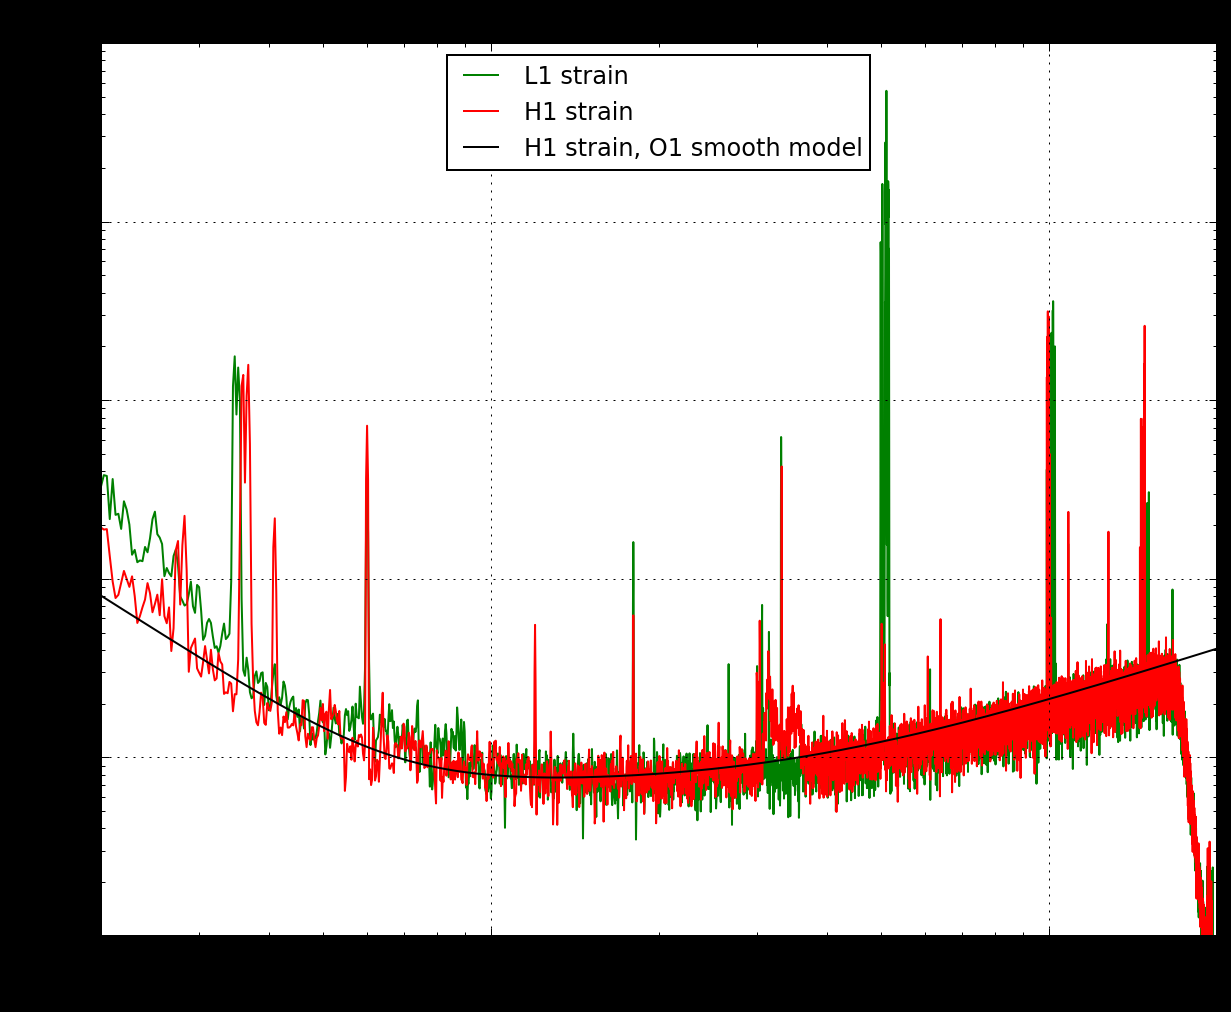

This is a sample from the authors of the paper (in the range of the lower plot, which is the most important).  
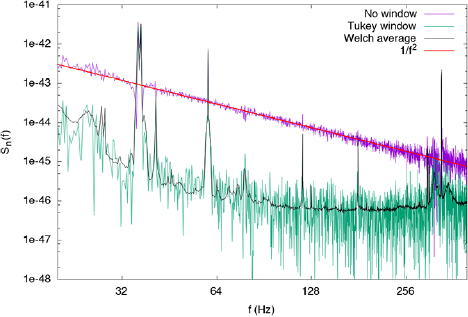

These look really quite similar, but if you have any idea wher there is room for improvement let me know!

### Whitening of the Signal
The Preprocessing that we are going to do is fairly simple: Resample the signal down, apply a tukey filter, decompose the signal using a fft, downweigh the common frequencies according to the spectrum and reconstruct the timeseries using an inverse Fourier transform. Then, apply a bandpass filter so we are just going to keep frequencies between 35 and 350 Hz (which, apparently are the only relevant signals).

In [ ]:
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter,butter, sosfilt

#lets test it with a single signal

#some parameters:
band = [15,200]


resampled_steps = test_ts.shape[-1]
resampled_sampling_freq = 2/resampled_steps

#do the fft
fft_test = np.fft.rfft(test_ts)

#record the frequencies of the decomposition
whitening_fft_freqs = np.fft.rfftfreq(resampled_steps, resampled_sampling_freq)

whitener = np.zeros((3,fft_test.shape[1]))
whitener[:,:] = 1./np.sqrt(1./(resampled_sampling_freq*2))

spectrum_0 = psd_0(whitening_fft_freqs)
spectrum_1 = psd_1(whitening_fft_freqs)
spectrum_2 = psd_2(whitening_fft_freqs)

whitener[0,:] /= np.sqrt(spectrum_0)
whitener[1,:] /= np.sqrt(spectrum_1)
whitener[2,:] /= np.sqrt(spectrum_2)


#whiten the test
whitened_test = fft_test * whitener
whitened_signal = np.fft.irfft(whitened_test)

#filter
sos = butter(4, band, btype='band', output='sos', fs=whitened_signal.shape[1]/2)
filtered_signal = sosfilt( sos, whitened_signal)



In [ ]:

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=[22,14])

ax[0].set_title(f'Original Signal')
ax[0].plot(test_ts[0].T, alpha=0.3)

ax[1].set_title(f'Whitened')
ax[1].plot(whitened_signal[0].T, alpha=1, linewidth=0.5)

ax[2].set_title(f'Bandpassed')
ax[2].plot(filtered_signal[0].T, alpha=1, linewidth=0.5)

plt.show()


Once again, I'm really not sure, if everything went well. Please let me know, if you find an error.

In [ ]:
#Now apply all of this processing to the entire dataset
# a function that takes an index in training_df and does all the processing
start_idx = Value('i', 0)

def whiten_signal(i):

    #load the signal
    filename = training_df['id'][i + start_idx.value]
    data_array = np.load(f'/kaggle/input/g2net-gravitational-wave-detection/train/{filename[0]}/{filename[1]}/{filename[2]}/{filename}.npy')

    #rfft
    fft_data = np.fft.rfft(data_array)

    #whiten
    fft_data *= whitener

    data_array = np.fft.irfft(fft_data)
    #inverse fft
    data_array = np.abs(data_array).astype(np.float32) * np.sign(data_array.real)

    #filter again
    data_array = sosfilt(sos, data_array).astype(np.float32)

    #write into the results
    data_array = np.ctypeslib.as_ctypes(data_array)
    target_array[i] = data_array

i= 0
no_samples = 100000

#generate a results array
target_array = np.zeros((no_samples, 3, test_ts.shape[1]), dtype=np.float32)
print(f'Target-Array-Size: {(target_array.size * target_array.itemsize)/(1024**3)}')

target_array = np.ctypeslib.as_ctypes(target_array)
target_array = sharedctypes.RawArray(target_array._type_, target_array)

#start index is here
start_idx = Value('i', (i)*no_samples)

gc.collect()



#prepare multiprocessing
idxs = np.arange(no_samples)
pool = Pool(processes=3)

#this takes about half an hour
a= pool.map(whiten_signal, idxs, chunksize=1024)

gc.collect()

# save it to disk after all the work
target_array = np.ctypeslib.as_array(target_array)
gc.collect()

np.save(f'train_signals{i}.npy', target_array)

In [ ]:
#Now apply all of this processing to the test Dataset
#load the target array just because
training_df = pd.read_csv('/kaggle/input/g2net-gravitational-wave-detection/sample_submission.csv')

no_samples = len(training_df.index)

#generate a results array
target_array = np.zeros((no_samples, 3, test_ts.shape[1]), dtype=np.float32)
print(f'Target-Array-Size: {(target_array.size * target_array.itemsize)/(1024**3)}')

target_array = np.ctypeslib.as_ctypes(target_array)
target_array = sharedctypes.RawArray(target_array._type_, target_array)

#start index is here
start_idx = Value('i', 0)

gc.collect()

# a function that takes an index in training_df and does all the processing
def whiten_signal(i):
    
    #load the signal
    filename = training_df['id'][i + start_idx.value]
    data_array = np.load(f'/kaggle/input/g2net-gravitational-wave-detection/test/{filename[0]}/{filename[1]}/{filename[2]}/{filename}.npy')
    
    #rfft
    fft_data = np.fft.rfft(data_array)
    
    #whiten
    fft_data *= whitener
    
    data_array = np.fft.irfft(fft_data)
    #inverse fft
    data_array = np.abs(data_array).astype(np.float32) * np.sign(data_array.real)
    
    #filter again
    data_array = sosfilt(sos, data_array).astype(np.float32)

    #write into the results
    data_array = np.ctypeslib.as_ctypes(data_array)
    target_array[i] = data_array
    
#prepare multiprocessing
idxs = np.arange(no_samples)
pool = Pool(processes=3)

#this takes about half an hour
a= pool.map(whiten_signal, idxs, chunksize=1024)

gc.collect()

In [ ]:
# save it to disk after all the work
target_array = np.ctypeslib.as_array(target_array)
gc.collect()

np.save('test_signals0.npy', target_array)

plt.plot(target_array[0].T, alpha=0.3)
plt.show()
plt.plot(target_array[100000].T, alpha=0.3)
plt.show()
plt.plot(target_array[200000].T, alpha=0.3)
plt.show()


Yess, we have converted all the signals to these weird looking signals.

## Revisit the average power spectrograms in Order to find out if we have been successful.

test_samples = 50000

Nfft = target_array.shape[2]
sampling_freq = 2/Nfft
tukey_window = windows.tukey(Nfft)

Pxx0, freqs0 = mlab.psd(target_array[:test_samples,0,:].reshape(test_samples*target_array.shape[2]),Fs=sampling_freq, NFFT=Nfft, window=tukey_window)
Pxx1, freqs1 = mlab.psd(target_array[:test_samples,1,:].reshape(test_samples*target_array.shape[2]),Fs=sampling_freq, NFFT=Nfft, window=tukey_window)
Pxx2, freqs2 = mlab.psd(target_array[:test_samples,2,:].reshape(test_samples*target_array.shape[2]),Fs=sampling_freq, NFFT=Nfft, window=tukey_window)


In [ ]:
f_min = band[0]
f_max = band[1]



fig, ax= plt.subplots(nrows=1, ncols=3, figsize=(16,9))

ax[0].loglog(freqs0, np.sqrt(Pxx0), 'b--', label='raw', alpha=0.5)
ax[0].set_xlim([f_min, f_max])

ax[1].loglog(freqs1, np.sqrt(Pxx1), 'b--', label='raw', alpha=0.5)
ax[1].set_xlim([f_min, f_max])

ax[2].loglog(freqs2, np.sqrt(Pxx2), 'b--', label='raw', alpha=0.5)
ax[2].set_xlim([f_min, f_max])

for ax_ in ax:
    ax_.legend()
    
plt.show()

The spectra seem pretty white, let's explore the frequency domain some more:

## Are all frequencies equally distributed for Noise and Signals?

target_value = training_df['target']
test_samples = 50000

Nfft = target_array.shape[2]
sampling_freq = Nfft/2
tukey_window = windows.tukey(Nfft)

Pxx0, freqs0 = mlab.psd(target_array[target_value == 0][:test_samples,0,:].reshape(test_samples*target_array.shape[2]),Fs=sampling_freq, NFFT=Nfft, window=tukey_window)
Pxx1, freqs1 = mlab.psd(target_array[target_value == 0][:test_samples,1,:].reshape(test_samples*target_array.shape[2]),Fs=sampling_freq, NFFT=Nfft, window=tukey_window)
Pxx2, freqs2 = mlab.psd(target_array[target_value == 0][:test_samples,2,:].reshape(test_samples*target_array.shape[2]),Fs=sampling_freq, NFFT=Nfft, window=tukey_window)

Pxx0p, freqs0 = mlab.psd(target_array[target_value == 1][:test_samples,0,:].reshape(test_samples*target_array.shape[2]),Fs=sampling_freq, NFFT=Nfft, window=tukey_window)
Pxx1p, freqs1 = mlab.psd(target_array[target_value == 1][:test_samples,1,:].reshape(test_samples*target_array.shape[2]),Fs=sampling_freq, NFFT=Nfft, window=tukey_window)
Pxx2p, freqs2 = mlab.psd(target_array[target_value == 1][:test_samples,2,:].reshape(test_samples*target_array.shape[2]),Fs=sampling_freq, NFFT=Nfft, window=tukey_window)

fig, ax= plt.subplots(nrows=1, ncols=3, figsize=(16,9))

ax[0].loglog(freqs0, np.sqrt(Pxx0), 'b--', label='negatives', alpha=0.5)
ax[0].set_xlim([f_min, f_max])

ax[1].loglog(freqs1, np.sqrt(Pxx1), 'b--', label='negatives', alpha=0.5)
ax[1].set_xlim([f_min, f_max])

ax[2].loglog(freqs2, np.sqrt(Pxx2), 'b--', label='negatives', alpha=0.5)
ax[2].set_xlim([f_min, f_max])


ax[0].loglog(freqs0, np.sqrt(Pxx0p), 'r--', label='positives', alpha=0.5)
ax[0].set_xlim([f_min, f_max])

ax[1].loglog(freqs1, np.sqrt(Pxx1p), 'r--', label='positives', alpha=0.5)
ax[1].set_xlim([f_min, f_max])

ax[2].loglog(freqs2, np.sqrt(Pxx2p), 'r--', label='positives', alpha=0.5)
ax[2].set_xlim([f_min, f_max])

for ax_ in ax:
    ax_.legend()
    
plt.show()

fig, ax= plt.subplots(nrows=1, ncols=3, figsize=(16,9))

ax[0].loglog(freqs0, np.sqrt(np.abs(Pxx0p - Pxx0)), 'b--', label='difference', alpha=0.5)
ax[0].set_xlim([f_min, f_max])

ax[1].loglog(freqs1, np.sqrt(np.abs(Pxx1p - Pxx1)), 'b--', label='difference', alpha=0.5)
ax[1].set_xlim([f_min, f_max])

ax[2].loglog(freqs2, np.sqrt(np.abs(Pxx2p - Pxx2)), 'b--', label='difference', alpha=0.5)
ax[2].set_xlim([f_min, f_max])


for ax_ in ax:
    ax_.legend()
    
plt.show()